# Collaborative Filtering Recommendation System with MovieLens Dataset

This notebook demonstrates how to build a collaborative filtering movie recommendation system using the MovieLens dataset. We will cover data loading, preprocessing, building a user-item matrix, applying collaborative filtering, and generating recommendations.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Explore the MovieLens Dataset

We will load the MovieLens dataset (movies.csv and ratings.csv) and perform basic exploration.

In [2]:
# Load MovieLens dataset (update the path if needed)
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# Display first few rows of movies and ratings
display(movies.head())
display(ratings.head())

# Check for missing values
print('Missing values in movies:')
print(movies.isnull().sum())
print('\nMissing values in ratings:')
print(ratings.isnull().sum())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Build User-Item Rating Matrix

We will create a user-item matrix where rows represent users and columns represent movies.

In [3]:
# Create user-item rating matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix.fillna(0, inplace=True)

print('User-Item matrix shape:', user_item_matrix.shape)
display(user_item_matrix.head())

User-Item matrix shape: (610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Collaborative Filtering: User-Based Similarity

We will compute user-user similarity and use it to recommend movies.

In [4]:
# Compute user-user similarity matrix
user_sim_matrix = cosine_similarity(user_item_matrix)

print('User-User similarity matrix shape:', user_sim_matrix.shape)

User-User similarity matrix shape: (610, 610)


## Build User-Based Collaborative Filtering Recommendation Function

We will implement a function to recommend movies to a user based on similar users' preferences.

In [5]:
# Function to recommend movies to a user based on user-user similarity
def recommend_movies_user_based(user_id, user_item_matrix, user_sim_matrix, movies_df, top_n=10):
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found.")
        return []
    # Get the index of the user
    user_idx = user_item_matrix.index.get_loc(user_id)
    # Get similarity scores for this user
    sim_scores = user_sim_matrix[user_idx]
    # Get ratings from all users
    user_ratings = user_item_matrix.values
    # Weighted sum of ratings by similarity
    weighted_ratings = np.dot(sim_scores, user_ratings)
    # Normalize by sum of similarities
    sim_sums = np.array([np.abs(sim_scores).sum() if np.abs(sim_scores).sum() != 0 else 1 for _ in range(user_ratings.shape[1])])
    pred_ratings = weighted_ratings / sim_sums
    # Get movies already rated by the user
    rated_movies = user_item_matrix.loc[user_id]
    unrated_indices = rated_movies[rated_movies == 0].index
    # Recommend top_n movies with highest predicted ratings
    top_indices = np.argsort(pred_ratings[[user_item_matrix.columns.get_loc(i) for i in unrated_indices]])[::-1][:top_n]
    recommended_movie_ids = [unrated_indices[i] for i in top_indices]
    return movies_df[movies_df['movieId'].isin(recommended_movie_ids)][['title', 'genres']]

## Generate Recommendations for a Sample User

Let's generate and display recommendations for a sample user.

In [6]:
# Generate recommendations for a sample user
sample_user_id = 1
print(f"Recommendations for User {sample_user_id}:")
recommendations = recommend_movies_user_based(sample_user_id, user_item_matrix, user_sim_matrix, movies, top_n=10)
display(recommendations)

Recommendations for User 1:


,title,genres
31,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
123,Apollo 13 (1995),Adventure|Drama|IMAX
277,"Shawshank Redemption, The (1994)",Crime|Drama
506,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
507,Terminator 2: Judgment Day (1991),Action|Sci-Fi
659,"Godfather, The (1972)",Crime|Drama
2078,"Sixth Sense, The (1999)",Drama|Horror|Mystery
3638,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4137,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
4800,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


## Evaluate Recommendation Results

Let's discuss and visualize the results. Optionally, we can compare recommendations with user ratings or preferences.

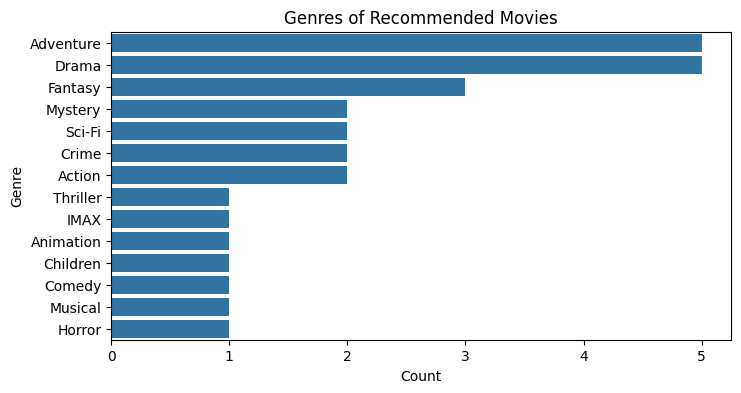

The recommended movies are selected based on ratings from similar users. You can further improve the system by using item-based collaborative filtering or matrix factorization techniques.


In [7]:
# Visualize genres of recommended movies
if not recommendations.empty:
    plt.figure(figsize=(8,4))
    genres = recommendations['genres'].str.split('|').explode()
    sns.countplot(y=genres, order=genres.value_counts().index)
    plt.title('Genres of Recommended Movies')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()
else:
    print('No recommendations to visualize.')

# Discussion:
print("The recommended movies are selected based on ratings from similar users. You can further improve the system by using item-based collaborative filtering or matrix factorization techniques.")